언어모델
- 자기만의 문법이 있음. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 개인의 구글 드라이브 폴더 path를 넣어줘야 합니다.
dir_path = '/content/drive/MyDrive/8_DL'

In [21]:
import os
os.chdir(dir_path) # 현재 경로 수정

In [22]:
import pandas as pd
# 전처리가 완료된 데이터
X_train = pd.read_pickle(f'{dir_path}/tf_train_inputs.pkl')
X_test = pd.read_pickle(f'{dir_path}/tf_test_inputs.pkl')
y_train = pd.read_pickle(f'{dir_path}/tf_train_labels.pkl')
y_test = pd.read_pickle(f'{dir_path}/tf_test_labels.pkl')

In [23]:
import json
config = json.load(open(f'{dir_path}/config.json', 'r')) 
# config.keys()
vocab = config['vocab']
vocab_size = config['vocab_size']

In [24]:
# embedding (output)_dim 크다 -> 
# 모델의 크기가 커진다. >> 파라미터 수가 커진다, 학습하는데 오래 걸린다.
# 벡터가 구체화 되어 과적합 위험이 커진다.

# embedding (output)_dim 작다.
# 단어, 문장의 의미를 제대로 파악하기 어렵다.

# 일반적으로 50~300 사이의 값을 사용하는 것이 좋다.

In [25]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid')) # 이진분류
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True) # epoch이 늘어나면 모델도 하나씩 늘어나는데 val_acc기준으로 성능이 가장 좋았던 모델을 쓰겠다! 중간중간 체크해주는거임

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 30, callbacks = [es, mc],
                    batch_size = 128, validation_split = 0.2)

Epoch 1/30
938/938 [==============================] - ETA: 0s - loss: 0.4519 - acc: 0.7807
Epoch 1: val_acc improved from -inf to 0.81443, saving model to best_model.h5
938/938 [==============================] - 21s 20ms/step - loss: 0.4519 - acc: 0.7807 - val_loss: 0.4042 - val_acc: 0.8144
Epoch 2/30
938/938 [==============================] - ETA: 0s - loss: 0.3826 - acc: 0.8299
Epoch 2: val_acc improved from 0.81443 to 0.81669, saving model to best_model.h5
938/938 [==============================] - 7s 8ms/step - loss: 0.3826 - acc: 0.8299 - val_loss: 0.4084 - val_acc: 0.8167
Epoch 3/30
938/938 [==============================] - ETA: 0s - loss: 0.3621 - acc: 0.8414
Epoch 3: val_acc improved from 0.81669 to 0.82263, saving model to best_model.h5
938/938 [==============================] - 7s 8ms/step - loss: 0.3621 - acc: 0.8414 - val_loss: 0.3871 - val_acc: 0.8226
Epoch 4/30
938/938 [==============================] - ETA: 0s - loss: 0.3449 - acc: 0.8515
Epoch 4: val_acc improved from 

In [26]:
# 확실히 머신러닝보다 딥러닝이 성능이 좋다!!(비정형은 거의 딥러닝이 좋음. 정형데이터 중에는 머신러닝이 좋은 경우도 있음!)

In [27]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

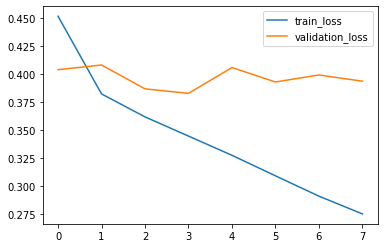

In [28]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

import matplotlib.pyplot as plt
plt.plot(range(len(loss)), loss, label = 'train_loss')
plt.plot(range(len(val_loss)), val_loss, label = 'validation_loss')
plt.legend()

# early stop한 이유..?

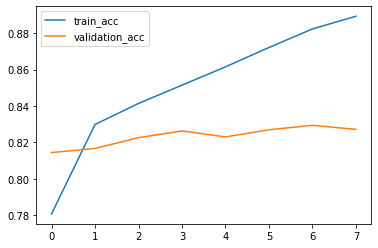

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(len(acc)), acc, label = 'train_acc')
plt.plot(range(len(val_acc)), val_acc, label = 'validation_acc')
plt.legend()

In [30]:
import pickle
# load the tokenizer from a file
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [31]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
load_model = load_model(f'{dir_path}/best_model.h5')

In [33]:
# text를 넣어 확률을 활용하여 리뷰를 예측하는 함수
text = '진짜 너무 재밌다.'
from tqdm import tqdm
from konlpy.tag import Okt
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def predict_text(text):
  # 데이터 전처리
  stopwords = ['의', '를', '와', '과', '으로', '것', '잘', '되', '주', '보', '수',
              '좀', '이', '있', '은', '한', '아', '도', '에', '하', '는', '자',
              '하다', '가', '들', '걍', '등']

  text = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', text)

  okt = Okt()
  tokenized_data = []

  tokenized_sentence = okt.morphs(text, stem = True)
  stopwords_removed_sentences = [token for token in tokenized_sentence if not token in stopwords]
  tokenized_data.append(stopwords_removed_sentences)

  # 벡터화
  sequences = tokenizer.texts_to_sequences(tokenized_data)

  SEQUENCE_MAX_LEN = 8
  inputs = pad_sequences(sequences , maxlen = SEQUENCE_MAX_LEN, padding = 'post')
  score = load_model.predict(inputs)[0]
  if score > 0.7:
    print(f'{round(score[0] * 100, 2)}% 긍정 리뷰 입니다.')
  else:
    print(f'{round(score[0] * 100, 2)}% 부정 리뷰 입니다.')
  return score


In [40]:
tt = predict_text('핵졸려...')

1/1 [==============================] - 0s 20ms/step
1.05% 부정 리뷰 입니다.
